In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib as mpl


plt.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.linewidth'] = 2 
set_tex = lambda tex=True: plt.rcParams.update({"text.usetex": tex})
mpl.rc('xtick', labelsize=12) 
mpl.rc('ytick', labelsize=12) 


In [2]:
np.random.seed(1)
rng = lambda n=2: np.random.randn(n, 2)

In [32]:
nu, kappa, rho, dt = 2.43, 2.87, -.94, 1. / 252.

In [193]:
step = {'daily': 1., 'weekly': 5., 'monthly' : 20.}

In [198]:
def diffuse_1FSV(s_0, n_samples = 10_000, T = 10., disc_step = 'daily'):
    disc_steps = int(T / (step[disc_step] * dt))
    spot, vol = np.zeros((n_samples, disc_steps + 1)), np.zeros((n_samples, disc_steps + 1))
    spot[:, 0] = s_0
    vol[:, 0] = 1.
    x = np.zeros(n_samples)

    for n in range(1, disc_steps + 1):
        z = rng(n_samples)
        spot[:, n] = spot[:, n - 1] * (1. + vol[:, n - 1] * np.sqrt(dt) * z[:, 0])
        x = x * (1. - kappa * dt) + (rho * z[:, 0] + np.sqrt(1. - rho**2) * z[:, 1]) * np.sqrt(dt)
        vol[:, n] = np.exp(nu * x)

    return spot, vol

In [281]:
import yfinance as yf

In [285]:
yf.stock_inf

TypeError: 'module' object is not callable

In [287]:
sx5e = yf.Ticker("^STOXX50E").history(start='2020-05-18')['Close']

2911.8798828125

In [291]:
s_0 = sx5e[0]
n_samples = 100_000

In [292]:
spot, vol = diffuse_1FSV(s_0, n_samples=n_samples, disc_step = 'weekly')

In [293]:
T = 10.
disc_steps = int(T / (step['weekly'] * dt))

In [294]:
t_grid = np.linspace(.0, T, disc_steps + 1)

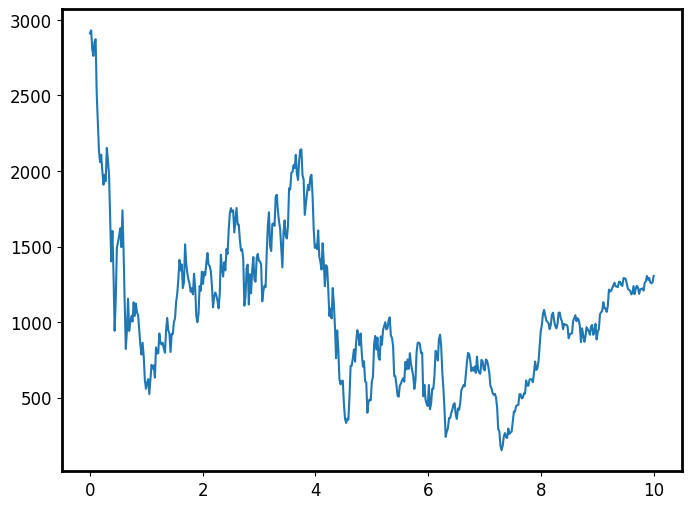

In [295]:
plt.plot(t_grid, spot[2, :], '-')

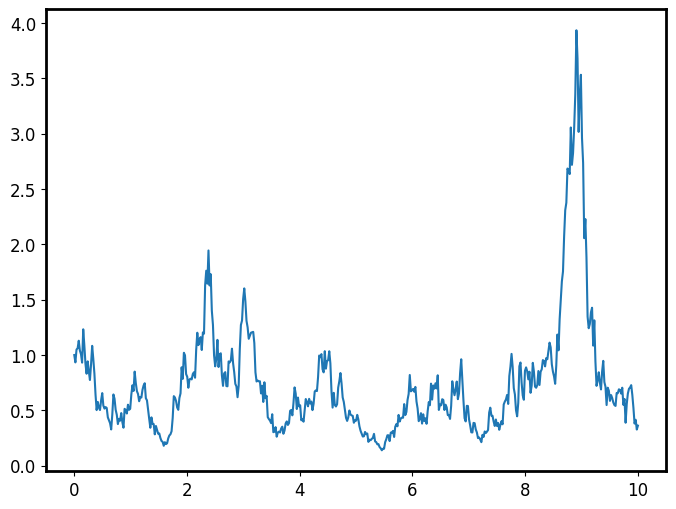

In [296]:
plt.plot(t_grid, vol[0, :])

In [297]:
tenor = np.array([.25, .5, 1., 2., 5., 7., 10.])
tenor_idx = (tenor / (step['weekly'] * dt)).astype(int)

In [298]:
spot_at_tenor = spot[:, tenor_idx]
vol_at_tenor = vol[:, tenor_idx]

In [299]:
def get_cov_correl(spot_at_tenor, vol_at_tenor):
    denom_=  (np.diff(spot_at_tenor, axis = 1)**2).cumsum(axis = 1) * (np.diff(vol_at_tenor, axis = 1)**2).cumsum(axis = 1)
    cov = (np.diff(spot_at_tenor, axis = 1) * np.diff(vol_at_tenor, axis = 1)).cumsum(axis = 1)
    return cov, cov / np.sqrt(denom_) 

In [300]:
cov, correl = get_cov_correl(spot_at_tenor, vol_at_tenor)

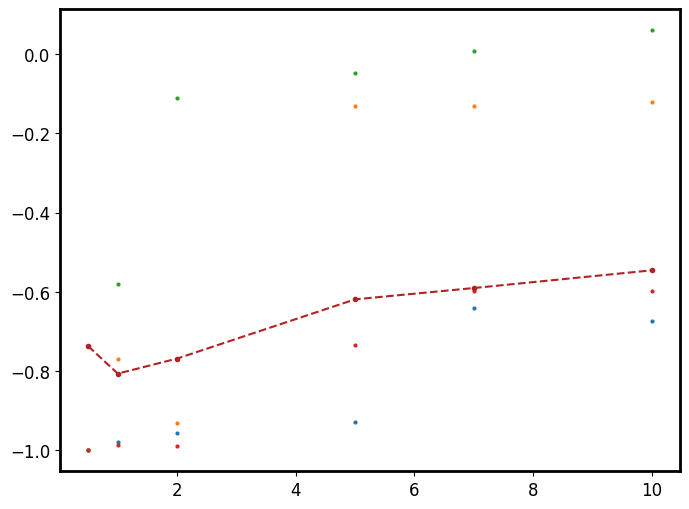

In [302]:
idx = [k for k in range(5) if k != 2]
for i in idx:
    plt.plot(tenor[1:], correl[i, :], '.', markersize = 4)
plt.plot(tenor[1:], correl.mean(0), '.--', color = 'firebrick')

In [178]:
tenor

array([ 0.25,  0.5 ,  1.  ,  2.  ,  5.  ,  7.  , 10.  ])

In [303]:
atmf_vols_1 = np.array([.24, .23, .22, .2, .19, .2, .2])
atmf_vols_2 = np.array([.4, .33, .26, .22, .21, .21, .21])

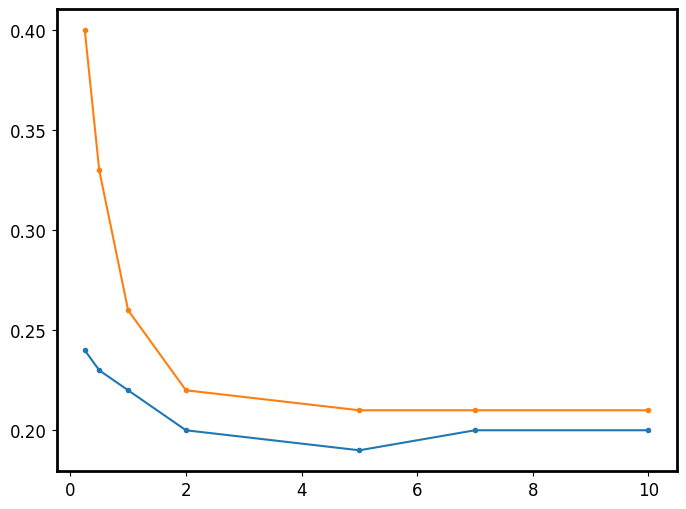

In [304]:
plt.plot(tenor, atmf_vols_1, '.-')
plt.plot(tenor, atmf_vols_2, '.-')


In [251]:
from scipy.interpolate import interp1d

In [316]:
atmf_var_func = interp1d(tenor, tenor * atmf_vols_2**2, kind = 'linear', fill_value='extrapolate')

In [317]:
tenor_ = np.array([.02, .08, .25, .5, .75] + [k for k in range(1, 11)])
tenor_

array([ 0.02,  0.08,  0.25,  0.5 ,  0.75,  1.  ,  2.  ,  3.  ,  4.  ,
        5.  ,  6.  ,  7.  ,  8.  ,  9.  , 10.  ])

In [318]:
atmf_vol_hat = np.sqrt(atmf_var_func(tenor_)) / np.sqrt(tenor_)

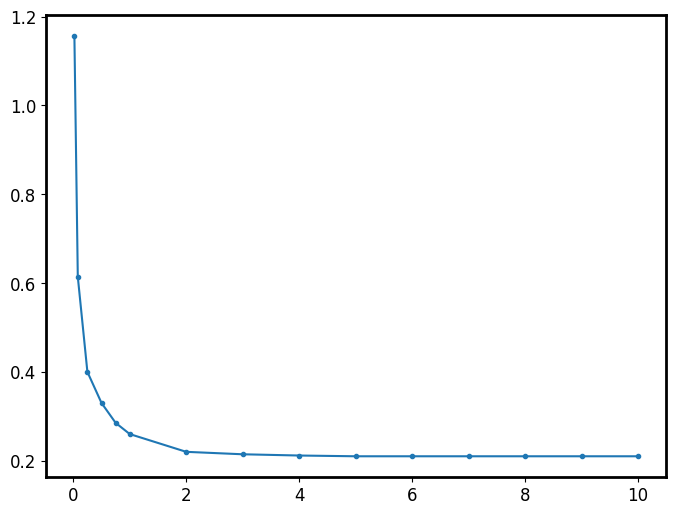

In [319]:
plt.plot(tenor_, atmf_vol_hat, '.-')

In [309]:
norm = stats.norm
def bs_greeks_scalar(s, sig, strikes, T = 1., t = 0., r = 0., type = 'delta'):
    d_1 = np.log(s * np.exp(r * (T - t)) / strikes) / (sig * np.sqrt(T - t)) + .5 * sig * np.sqrt(T - t)
    d_2 = d_1 - sig * np.sqrt(T - t)

    match type:
        case 'delta':
            return norm.cdf(d_1)
        case 'gamma':
            return norm.pdf(d_1) / (s * sig * np.sqrt(T - t))
        case 'vega':
            return s * np.sqrt(T - t) * norm.pdf(d_1)
        case 'c_k':
            return - np.exp(-r * (T - t)) * norm.cdf(d_2)
bs_greeks = np.vectorize(bs_greeks_scalar, excluded={'t', 'r', 'type'})

In [320]:
def get_atmf_skew(tenor, spot_at_tenor, atmf_vol):
    vega_bs = bs_greeks(s = s_0, sig = atmf_vol, T = tenor, strikes = s_0, type = 'vega')
    c_k = bs_greeks(s = s_0, sig = atmf_vol, T = tenor, strikes = s_0, type = 'c_k')

    binary = (spot_at_tenor > s_0).mean(axis = 0)
    return - (binary + c_k) / vega_bs

In [321]:
tenor_idx_ = (tenor_ / (step['weekly'] * dt)).astype(int)

In [322]:
spot_at_tenor = spot[:, tenor_idx_]

In [323]:
atmf_skew = get_atmf_skew(tenor_, spot_at_tenor, atmf_vol_hat)

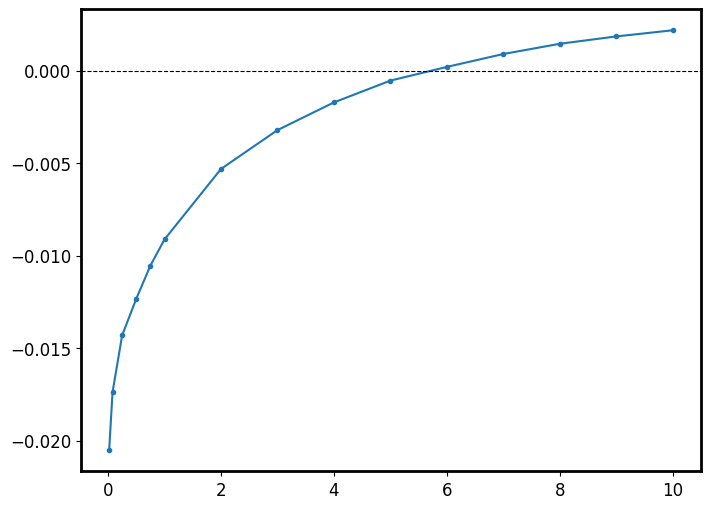

In [324]:
plt.plot(tenor_, atmf_skew * 1e2, '.-')
plt.axhline(y = 0., linestyle = 'dashed', lw = .8, color = 'k')